# Suvival analysis of employee turnover
### Vincent Swiderski & Benoit Mialet


In [25]:
# !pip install lifelines

In [27]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import logrank_test, multivariate_logrank_test, pairwise_logrank_test
from lifelines.utils import find_best_parametric_model

## Description of the data 
Source : https://www.kaggle.com/davinwijaya/employee-turnover

The dataset contains 1129 observations of 16 variables:
* stag: time experience (months) in the company
* event: occurrence of the event "quitting the company"
* gender: gender of the employee
* age: age of the employee in years
* industry: economic sector of the company (retail, manufacturing etc)
* profession: work area of the employee (HR, IT etc)
* traffic: entry point for hiring the employee
* coach: presence of a coach on probation ("my_head"= "my superior is also my coach")
* head_gender: gender of the employee’s manager
* greywage: salary legal framework (in Russia/Ukrain: white means declared in a contract, grey means partially declared and partially payed in cash).
* way: how the employee gets to workplace (feet, bus or car)
* The "Big Five" personality traits (marks out of 5 - Golberg et al., 1992):
  * novator: openness to experience (low = consistent/cautious, high = inventive/curious)
  * selfcontrol: conscientiousness (low = extravagant/careless, high = efficient/organized)
  * extravert: extraversion (low = solitary/reserved, high = outgoing/energetic)
  * independ: opposite of big 5 "agreeableness" (low = friendly/compassionate, high = critical/rational)
  * anxiety: neuroticism (low = resilient/confident, high = sensitive/nervous)



## Data preparation

Importing

In [3]:
path = 'https://github.com/benoitmialet/Survival-analysis-with-Lifelines-for-Python/raw/main/employee_turnover.csv'
df_attrition = pd.read_csv(path, sep = ',', encoding='latin-1')
df_attrition.head(8)

,stag,event,gender,age,industry,profession,traffic,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator
0,7.030801,1,m,35.0,Banks,HR,rabrecNErab,no,f,white,bus,6.2,4.1,5.7,7.1,8.3
1,22.965092,1,m,33.0,Banks,HR,empjs,no,m,white,bus,6.2,4.1,5.7,7.1,8.3
2,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,6.2,6.2,2.6,4.8,8.3
3,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,5.4,7.6,4.9,2.5,6.7
4,8.410678,1,m,32.0,Retail,Commercial,youjs,yes,f,white,bus,3.0,4.1,8.0,7.1,3.7
5,8.969199,1,f,42.0,manufacture,HR,empjs,yes,m,white,bus,6.2,6.2,4.1,5.6,6.7
6,8.969199,1,f,42.0,manufacture,HR,empjs,yes,m,white,bus,6.2,6.2,4.1,5.6,6.7
7,120.443532,1,f,28.0,Retail,HR,referal,no,m,white,bus,3.8,5.5,8.0,4.0,4.4


Data overview

In [96]:
# count null data
sum(df_attrition.isnull().any())

0

In [ ]:
# Overview of categories
for var in df_attrition:
    if df_attrition[var].dtype != 'float64' and df_attrition[var].dtype != "int64" :
        print(df_attrition[var].name)
        print(df_attrition[var].value_counts())

gender
f    853
m    276
Name: gender, dtype: int64
industry
Retail             289
manufacture        145
IT                 122
Banks              114
etc                 94
Consult             74
State               55
Building            41
PowerGeneration     38
transport           38
Telecom             36
Mining              24
Pharma              20
Agriculture         15
RealEstate          13
 HoReCa             11
Name: industry, dtype: int64
profession
HR                     757
IT                      74
Sales                   66
etc                     37
Marketing               31
BusinessDevelopment     27
Consult                 25
Commercial              23
manage                  22
Finanñe                 17
Engineer                15
Teaching                12
Accounting              10
Law                      7
PR                       6
Name: profession, dtype: int64
traffic
youjs          318
empjs          248
rabrecNErab    211
friends        118
referal    

Selecting variables, changing scales

In [73]:
# Few information is available about traffic variable. We dediced to drop it   
df_attrition = df_attrition.drop(columns=['traffic'])
# Changing object type variables into categorical variables
object_variables = list(df_attrition.select_dtypes(include=['object']).columns)
df_attrition.loc[:,object_variables] = df_attrition.loc[:,object_variables].astype('category')
# rename Industry 'etc' category into 'others'
df_attrition['industry'] =  df_attrition['industry'].cat.rename_categories({'etc':'others'})
# rename Profession 'etc' and 'Finanñe' categories into 'others' and 'Finance'
df_attrition['profession'] =  df_attrition['profession'].cat.rename_categories({'etc':'others', 'Finanñe' : 'Finance'})
# Express experience in the company as years instead of months
df_attrition['stag'] = df_attrition['stag']/12
# Express age of the subject in decades instead of years
df_attrition['age'] = df_attrition['age']/10
# Express the Big five factors on a [0;1] scale instead of [0;10] 
df_attrition[['independ', 'extraversion', 'selfcontrol', 'anxiety',	'novator']] = df_attrition[['independ', 'extraversion', 'selfcontrol', 'anxiety',	'novator']]/10

df_attrition.head(8)

,stag,event,gender,age,industry,profession,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator
0,0.585900,1,m,3.5,Banks,HR,no,f,white,bus,0.62,0.41,0.57,0.71,0.83
1,1.913758,1,m,3.3,Banks,HR,no,m,white,bus,0.62,0.41,0.57,0.71,0.83
2,1.327858,1,f,3.5,PowerGeneration,HR,no,m,white,bus,0.62,0.62,0.26,0.48,0.83
3,1.327858,1,f,3.5,PowerGeneration,HR,no,m,white,bus,0.54,0.76,0.49,0.25,0.67
4,0.700890,1,m,3.2,Retail,Commercial,yes,f,white,bus,0.30,0.41,0.80,0.71,0.37
5,0.747433,1,f,4.2,manufacture,HR,yes,m,white,bus,0.62,0.62,0.41,0.56,0.67
6,0.747433,1,f,4.2,manufacture,HR,yes,m,white,bus,0.62,0.62,0.41,0.56,0.67
7,10.036961,1,f,2.8,Retail,HR,no,m,white,bus,0.38,0.55,0.80,0.40,0.44


### One Hot Encoding
We used One hot encoding to build a Cox Proportional Hazard analysis. One hot encoding classical method with pandas (and other Python libraries) takes by default the **first** indexed category as reference. We wanted to choose which category to set as reference for each variable. So we made it in 3 steps: 

1) List categories and check names. categories starting with spaces and Capitals go first in index order 

In [74]:
for column in df_attrition:
    if df_attrition[column].dtype != 'float64' and df_attrition[column].dtype != "int64" :
        print(df_attrition[column].name)
        print(df_attrition[column].cat.categories)

gender
Index(['f', 'm'], dtype='object')
industry
Index([' HoReCa', 'Agriculture', 'Banks', 'Building', 'Consult', 'IT',
       'Mining', 'Pharma', 'PowerGeneration', 'RealEstate', 'Retail', 'State',
       'Telecom', 'others', 'manufacture', 'transport'],
      dtype='object')
profession
Index(['Accounting', 'BusinessDevelopment', 'Commercial', 'Consult',
       'Engineer', 'Finance', 'HR', 'IT', 'Law', 'Marketing', 'PR', 'Sales',
       'Teaching', 'others', 'manage'],
      dtype='object')
coach
Index(['my head', 'no', 'yes'], dtype='object')
head_gender
Index(['f', 'm'], dtype='object')
greywage
Index(['grey', 'white'], dtype='object')
way
Index(['bus', 'car', 'foot'], dtype='object')


2)  Define reference categories for each variable, by reorganizing categories order, so that the first one will be taken as reference category


In [75]:
df_attrition.industry = df_attrition.industry.cat.reorder_categories(['Retail', 'IT', ' HoReCa', 'Agriculture', 'Banks', 'Building', 'Consult',
       'Mining', 'Pharma', 'PowerGeneration', 'RealEstate', 'State',
       'Telecom', 'others', 'manufacture', 'transport'])
print(df_attrition.industry.cat.categories)
df_attrition.profession = df_attrition.profession.cat.reorder_categories(['HR', 'IT', 'Accounting', 'BusinessDevelopment', 'Commercial', 'Consult',
       'Engineer', 'Finance', 'Law', 'Marketing', 'PR', 'Sales',
       'Teaching', 'others', 'manage'])
print(df_attrition.profession.cat.categories)
df_attrition.coach = df_attrition.coach.cat.reorder_categories(['no', 'my head', 'yes'])
print(df_attrition.coach.cat.categories)

Index(['Retail', 'IT', ' HoReCa', 'Agriculture', 'Banks', 'Building',
       'Consult', 'Mining', 'Pharma', 'PowerGeneration', 'RealEstate', 'State',
       'Telecom', 'others', 'manufacture', 'transport'],
      dtype='object')
Index(['HR', 'IT', 'Accounting', 'BusinessDevelopment', 'Commercial',
       'Consult', 'Engineer', 'Finance', 'Law', 'Marketing', 'PR', 'Sales',
       'Teaching', 'others', 'manage'],
      dtype='object')
Index(['no', 'my head', 'yes'], dtype='object')


3) Encode in one hot

In [76]:
dummies = pd.get_dummies(df_attrition[['gender', 'industry', 'profession', 'coach','head_gender', 'greywage', 'way']], drop_first=True)
df_attrition_one_hot_enc = pd.concat([df_attrition.drop(['gender', 'industry', 'profession', 'coach','head_gender', 'greywage', 'way'],axis=1), dummies],axis=1)
df_attrition_one_hot_enc.head(8)

,stag,event,age,extraversion,independ,selfcontrol,anxiety,novator,gender_m,industry_IT,industry_ HoReCa,industry_Agriculture,industry_Banks,industry_Building,industry_Consult,industry_Mining,industry_Pharma,industry_PowerGeneration,industry_RealEstate,industry_State,industry_Telecom,industry_others,industry_manufacture,industry_transport,profession_IT,profession_Accounting,profession_BusinessDevelopment,profession_Commercial,profession_Consult,profession_Engineer,profession_Finance,profession_Law,profession_Marketing,profession_PR,profession_Sales,profession_Teaching,profession_others,profession_manage,coach_my head,coach_yes,head_gender_m,greywage_white,way_car,way_foot
0,0.585900,1,3.5,0.62,0.41,0.57,0.71,0.83,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1.913758,1,3.3,0.62,0.41,0.57,0.71,0.83,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
2,1.327858,1,3.5,0.62,0.62,0.26,0.48,0.83,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
3,1.327858,1,3.5,0.54,0.76,0.49,0.25,0.67,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,0.700890,1,3.2,0.30,0.41,0.80,0.71,0.37,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
5,0.747433,1,4.2,0.62,0.62,0.41,0.56,0.67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0
6,0.747433,1,4.2,0.62,0.62,0.41,0.56,0.67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0
7,10.036961,1,2.8,0.38,0.55,0.80,0.40,0.44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


Histograms

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff5b2223f90>,
      dtype=object)

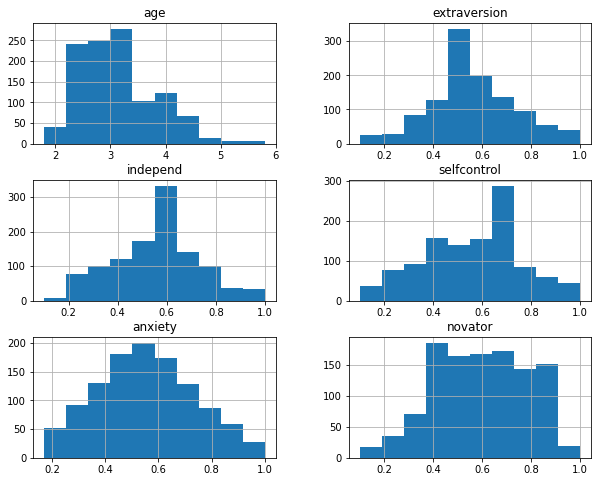

In [ ]:
#histograms of numerical variables
df_attrition.drop(['stag', 'event'], axis=1).hist(figsize=(10, 8))

## Survival Regression: Cox proportional hazard semi-parametric model


### Backward variable selection using AIC criterion on CPH regression
https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#model-selection-based-on-predictive-power-and-fit



Lifelines library doesn't include any automatic (forward, backward, stepwise) variable selection process with the various criterion availables.

We thus coded a backward selection method in order to build the CPH model: 

In [91]:
def backward_selection_coxph(df, time_feature_name, event_feature_name, penalizer_val = 0.1, l1_ratio_val = 0, verbose = False):
    # initialization
    feature_list = list(df.drop(columns = [time_feature_name, event_feature_name]).columns[:])
    current_model = CoxPHFitter(penalizer = penalizer_val, l1_ratio = l1_ratio_val).fit(df, time_feature_name, event_feature_name)
    best_model = current_model
    #
    for i in range(len(feature_list)):
    print(f'Cycle {i+1}. Features: {feature_list}')
    print(f'Removing features:')
    better_model_found = False
    for f in feature_list:
        temp_df = df.drop(columns = [f])
        model = CoxPHFitter(penalizer = penalizer_val, l1_ratio = l1_ratio_val).fit(temp_df, time_feature_name, event_feature_name)
        if model.AIC_partial_ < best_model.AIC_partial_:
            best_model = model
            feature_to_drop = f
            better_model_found = True
        if verbose == True:
            print(f"-> Removing {f:<30}AIC: {model.AIC_partial_}")
    if better_model_found == False:
        break
    else:
        print(f"Feature droppped: {feature_to_drop:<30}AIC: {best_model.AIC_partial_}\n")
        df = df.drop(columns = [feature_to_drop])
        feature_list = list(df.drop(columns = [time_feature_name, event_feature_name]).columns[:])

    print(f"\nBest Model found! AIC: {best_model.AIC_partial_}")
    print(f"Features: {feature_list} Summary:")
    print(best_model.summary)
    return best_model

we execute our backward selection method on the data

In [92]:
final_model = backward_selection_coxph(df_attrition_one_hot_enc, 'stag', 'event', verbose = True)

Cycle 1. Features: ['age', 'extraversion', 'independ', 'selfcontrol', 'anxiety', 'novator', 'gender_m', 'industry_IT', 'industry_ HoReCa', 'industry_Agriculture', 'industry_Banks', 'industry_Building', 'industry_Consult', 'industry_Mining', 'industry_Pharma', 'industry_PowerGeneration', 'industry_RealEstate', 'industry_State', 'industry_Telecom', 'industry_others', 'industry_manufacture', 'industry_transport', 'profession_IT', 'profession_Accounting', 'profession_BusinessDevelopment', 'profession_Commercial', 'profession_Consult', 'profession_Engineer', 'profession_Finance', 'profession_Law', 'profession_Marketing', 'profession_PR', 'profession_Sales', 'profession_Teaching', 'profession_others', 'profession_manage', 'coach_my head', 'coach_yes', 'head_gender_m', 'greywage_white', 'way_car', 'way_foot']
Removing features:
-> Removing age                           AIC: 6923.707883432389
-> Removing extraversion                  AIC: 6913.845182376157
-> Removing independ                 

Here is our final model once the most influent variables were selected: 

Text(0.5, 0, 'Hazard Ratio (95% Confidence Interval)')

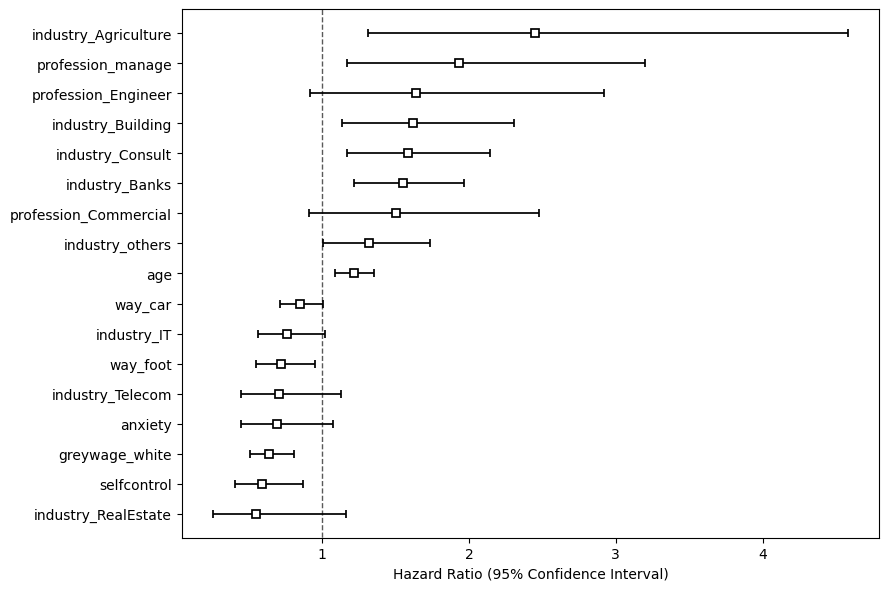

In [93]:
plt.figure(figsize=(9, 7), dpi=100)
final_model.plot(hazard_ratios=True)
# plt.title("Cox Proportional Hazard model")
plt.xlabel("Hazard Ratio (95% Confidence Interval)")

In [110]:
# final_model.summary
# add style='latex' amon the arguments if needed
final_model.print_summary(columns=["exp(coef)", "exp(coef) lower 95%", "exp(coef) upper 95%", "z", "p"])  

<lifelines.CoxPHFitter: fitted with 1129 total observations, 558 right-censored observations>
             duration col = 'stag'
                event col = 'event'
                penalizer = 0.1
                 l1 ratio = 0
      baseline estimation = breslow
   number of observations = 1129
number of events observed = 571
   partial log-likelihood = -3422.13
         time fit was run = 2022-01-26 13:13:58 UTC

---
                       exp(coef)  exp(coef) lower 95%  exp(coef) upper 95%     z      p
covariate                                                                              
age                         1.21                 1.09                 1.35  3.46 <0.005
selfcontrol                 0.59                 0.40                 0.87 -2.70   0.01
anxiety                     0.69                 0.45                 1.07 -1.64   0.10
industry_IT                 0.76                 0.56                 1.02 -1.84   0.07
industry_Agriculture        2.45                 1.31                 4.58  2.80   0.01
industry_Banks              1.55                 1.22                 1.97  3.57 <0.005
industry_Building           1.62                 1.13                 2.31  2.65   0.01
industry_Consult            1.58                 1.17                 2.14  2.98 <0.005
industry_RealEstate         0.55                 0.26                 1.16 -1.57   0.12
industry_Telecom            0.71                 0.44                 1.12 -1.46   0.14
industry_others             1.32                 1.01                 1.73  2.00   0.05
profession_Commercial       1.50                 0.91                 2.48  1.60   0.11
profession_Engineer         1.63                 0.91                 2.92  1.66   0.10
profession_manage           1.93                 1.17                 3.20  2.55   0.01
greywage_white              0.64                 0.50                 0.81 -3.72 <0.005
way_car                     0.85                 0.71                 1.00 -1.94   0.05
way_foot                    0.72                 0.55                 0.95 -2.30   0.02
---
Concordance = 0.63
Partial AIC = 6878.25
log-likelihood ratio test = 96.35 on 17 df
-log2(p) of ll-ratio test = 41.11

In [100]:
final_model.log_likelihood_ratio_test()

<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 17
        test_name = log-likelihood ratio test

---
 test_statistic      p  -log2(p)
          96.35 <0.005     41.11

### Plotting the effect of varying a covariate
https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#plotting-the-effect-of-varying-a-covariate

Text(0.5, 0, 'Experience in the company (years)')

<Figure size 700x500 with 0 Axes>

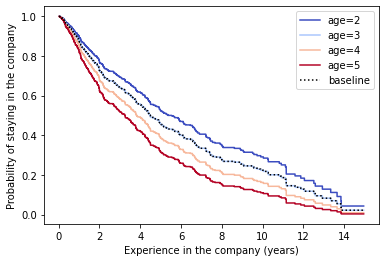

In [108]:
plt.figure(figsize=(7, 5), dpi=100)
final_model.plot_partial_effects_on_outcome(covariates='age', values=[2, 3, 4, 5], cmap='coolwarm')
# final_model.plot_partial_effects_on_outcome(covariates='selfcontrol', values=[0.2, 0.4, 0.6, 0.8, 1], cmap='coolwarm')
plt.ylabel("Probability of staying in the company")
plt.xlabel("Experience in the company (years)")

## Testing proportional hazard assumption with Schoenfeld residuals
https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html?highlight=hazard

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1129 total observations, 558 right-censored observations>
         test_name = proportional_hazard_test

---
                                     test_statistic    p  -log2(p)
age                            km              0.16 0.69      0.54
                               rank            0.09 0.76      0.40
anxiety                        km              1.61 0.20      2.29
                               rank            1.10 0.29      1.76
coach_my head                  km              4.02 0.04      4.48
                               rank            5.33 0.02      5.58
coach_yes                      km              0.22 0.64      0.65
                               rank            0.23 0.63      0.66
extraversion                   km              2.96 0.09      3.55
                               rank            2.08 0.15      2.74
gender_m                       km              0.06 0.81      0.30
                               rank            0.04 0.84      0.25
greywage_white                 km              0.09 0.76      0.39
                               rank            0.07 0.80      0.32
head_gender_m                  km              0.13 0.72      0.48
                               rank            0.12 0.73      0.46
independ                       km              0.39 0.53      0.91
                               rank            0.01 0.94      0.09
industry_ HoReCa               km              0.08 0.78      0.37
                               rank            0.48 0.49      1.03
industry_Agriculture           km              1.42 0.23      2.10
                               rank            1.73 0.19      2.41
industry_Banks                 km              0.58 0.44      1.17
                               rank            0.22 0.64      0.64
industry_Building              km              0.16 0.69      0.53
                               rank            0.15 0.70      0.52
industry_Consult               km              0.28 0.60      0.74
                               rank            0.09 0.77      0.38
industry_IT                    km              0.08 0.78      0.36
                               rank            0.27 0.61      0.72
industry_Mining                km              0.50 0.48      1.06
                               rank            0.24 0.63      0.68
industry_Pharma                km              0.59 0.44      1.17
                               rank            0.97 0.32      1.62
industry_PowerGeneration       km              0.54 0.46      1.11
                               rank            0.17 0.68      0.55
industry_RealEstate            km              0.38 0.54      0.90
                               rank            0.19 0.66      0.59
industry_State                 km              0.52 0.47      1.09
                               rank            0.24 0.62      0.68
industry_Telecom               km              0.60 0.44      1.19
                               rank            0.95 0.33      1.60
industry_manufacture           km              2.31 0.13      2.96
                               rank            2.06 0.15      2.72
industry_others                km              2.64 0.10      3.26
                               rank            2.68 0.10      3.30
industry_transport             km              0.37 0.55      0.87
                               rank            0.37 0.54      0.89
novator                        km              4.67 0.03      5.03
                               rank            5.68 0.02      5.86
profession_Accounting          km              3.63 0.06      4.14
                               rank            1.53 0.22      2.21
profession_BusinessDevelopment km              0.82 0.37      1.45
                               rank            0.76 0.38      1.39
profession_Commercial          km    



1. Variable 'selfcontrol' failed the non-proportional test: p-value is 0.0245.

   Advice 1: the functional form of the variable 'selfcontrol' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'selfcontrol' using pd.cut, and then specify it in
`strata=['selfcontrol', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


2. Variable 'novator' failed the non-proportional test: p-value is 0.0172.

   Advice 1: the functional form of the variable 'novator' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. Se

[[<matplotlib.axes._subplots.AxesSubplot at 0x7f2eb1fe0250>,

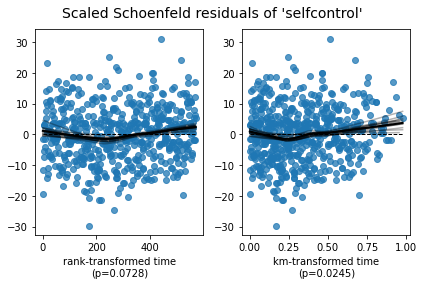

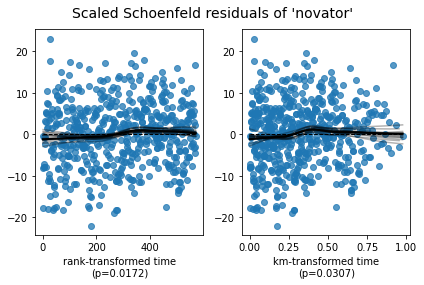

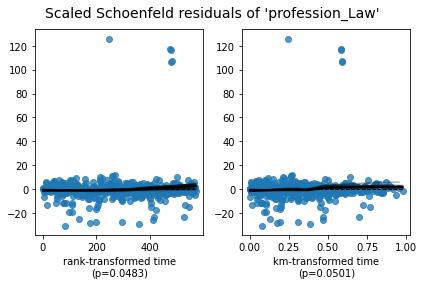

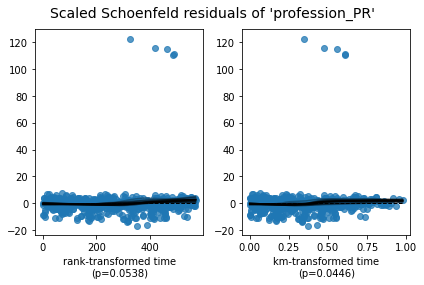

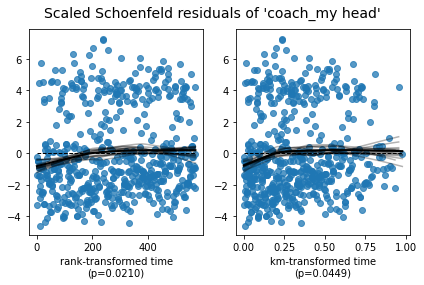

In [ ]:
cph = CoxPHFitter()
cph.fit(df_attrition_one_hot_enc, duration_col='stag', event_col='event')
cph.check_assumptions(df_attrition_one_hot_enc, p_value_threshold=0.05, show_plots=True)

### Martingale residuals to identify patterns between the variable and its residuals

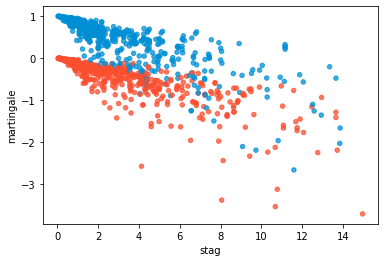

In [ ]:
import numpy as np
r = cph.compute_residuals(df_attrition_one_hot_enc, 'martingale')
r.plot.scatter(
    x='stag', y='martingale', c=np.where(r['event'], '#008fd5', '#fc4f30'),
    alpha=0.75
)

## Non parametric survival estimation and testing: Kaplan-Meier estimator
https://lifelines.readthedocs.io/en/latest/Quickstart.html

Text(0.5, 0, 'Experience in the company (years)')

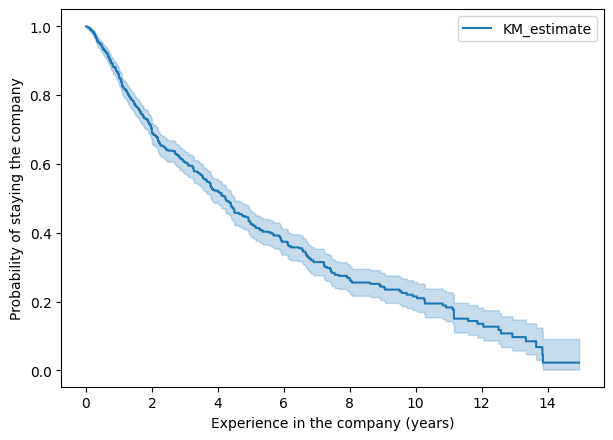

In [77]:
kmf = KaplanMeierFitter()
kmf.fit(df_attrition.stag, df_attrition.event)
plt.figure(figsize=(7, 5), dpi=100)
kmf.survival_function_
kmf.cumulative_density_
kmf.plot_survival_function()
# plt.title("Kaplan-Meier estimator for attrition")
plt.ylabel("Probability of staying the company")
plt.xlabel("Experience in the company (years)")

Computing the median: maximum time (years) such that probability of staying in the activity is superior or equal than 0.5

In [ ]:
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(f'median: {median_}\nCI:{median_confidence_interval_}')
# print(f'median: {median_}')
# median_confidence_interval_

median: 4.227241615
CI:     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                3.794661                4.501027


Cumulative density function

Text(0.5, 0, 'Experience in the company (years)')

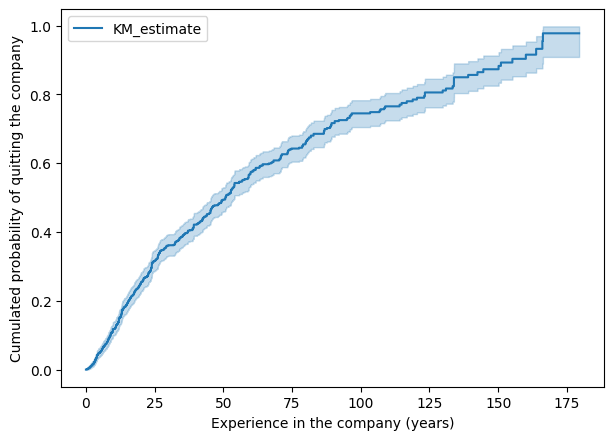

In [29]:
kmf = KaplanMeierFitter()
kmf.fit(df_attrition.stag, df_attrition.event)
plt.figure(figsize=(7, 5), dpi=100)
kmf.plot_cumulative_density()
# plt.title("Kaplan-Meier estimator for attrition")
plt.ylabel("Cumulated probability of quitting the company")
plt.xlabel("Experience in the company (years)")

### Comparing two groups
#### graphs & medians


Gender-Female 
median: 4.0082135525
CI:     Females_lower_0.95  Females_upper_0.95
0.5            3.548255            4.413415

Gender-Male 
median: 4.8186173850000005
CI:     Males_lower_0.95  Males_upper_0.95
0.5          4.109514          5.357974



Text(0.5, 0, 'Experience in the company (years)')

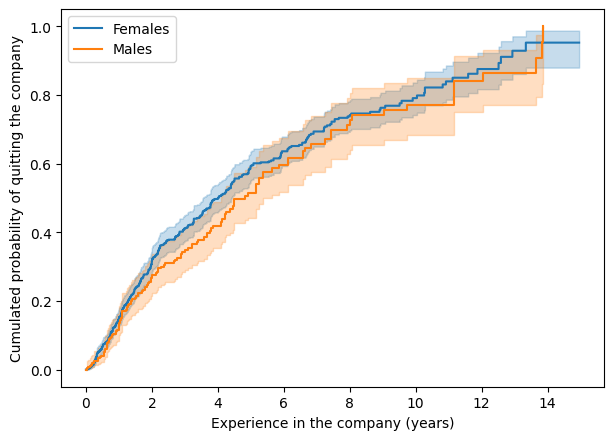

In [ ]:
plt.figure(figsize=(7, 5), dpi=100)
groups = df_attrition.gender
males = (groups == 'm')

kmf.fit(df_attrition.stag[~males], df_attrition.event[~males], label='Females')
ax = kmf.plot_cumulative_density()
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(f'Gender-Female \nmedian: {median_}\nCI:{median_confidence_interval_}\n')

kmf.fit(df_attrition.stag[males], df_attrition.event[males], label='Males')
ax = kmf.plot_cumulative_density(ax=ax)
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(f'Gender-Male \nmedian: {median_}\nCI:{median_confidence_interval_}\n')

# plt.title("Kaplan-Meier estimator for attrition")
plt.ylabel("Cumulated probability of quitting the company")
plt.xlabel("Experience in the company (years)")

using loops

greywage_grey
Median: 2.1273100616666665
CI:      grey_lower_0.95  grey_upper_0.95
0.5         1.598905         2.836413

greywage_white
Median: 4.432580424166667
CI:      white_lower_0.95  white_upper_0.95
0.5           4.03833          4.933607



Text(0.5, 0, 'Experience in the company (years)')

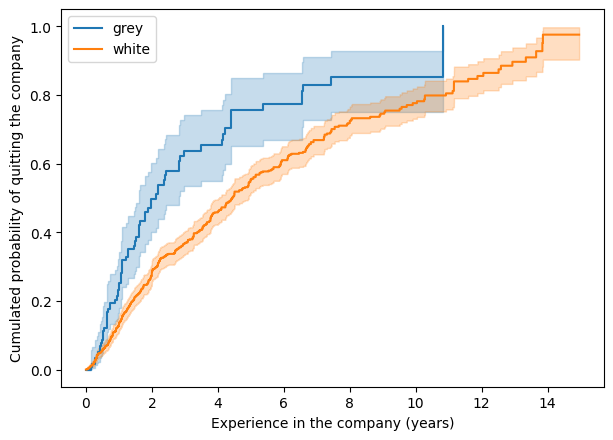

In [ ]:
plt.figure(figsize=(7, 5), dpi=100)
ax = plt.subplot()

kmf = KaplanMeierFitter()
variable_name = 'greywage'

for name, grouped_df in df_attrition.groupby(variable_name):
    kmf.fit(grouped_df.stag, grouped_df.event, label=name)
    ax = kmf.plot_cumulative_density(ax=ax)
    median_ = kmf.median_survival_time_
    median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
    print(f'{variable_name}_{name}\nMedian: {median_}\nCI: {median_confidence_interval_}\n')

# plt.title("Kaplan-Meier estimator for attrition")
plt.ylabel("Cumulated probability of quitting the company")
plt.xlabel("Experience in the company (years)")

#### logrank test between 2 groups

men vs women

In [ ]:
males = df_attrition['gender'] == 'm'
stag_m, event_m = df_attrition.loc[males, 'stag'], df_attrition.loc[males, 'event']
stag_f, event_f = df_attrition.loc[~males, 'stag'], df_attrition.loc[~males, 'event']

results = logrank_test(stag_m, stag_f, event_observed_A = event_m, event_observed_B=event_f)
results.print_summary()

print(results.p_value)
print(results.test_statistic)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           2.35 0.13      2.99

0.12544975834605587
2.3479266755929187


wage grey vs white

In [ ]:
white = df_attrition['greywage'] == 'white'
stag_w, event_w = df_attrition.loc[white, 'stag'], df_attrition.loc[white, 'event']
stag_g, event_g = df_attrition.loc[~white, 'stag'], df_attrition.loc[~white, 'event']

results = logrank_test(stag_w, stag_g, event_observed_A = event_w, event_observed_B = event_g)
results.print_summary()

print(results.p_value)
print(results.test_statistic)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          22.34 <0.005     18.74

2.2793196606280822e-06
22.343933220342322


### Comparing multiple groups
Effect of way of locomotion & wage on attrition

#### graphs

way_bus
Median: 0.31508099472222223
CI:      bus_lower_0.95  bus_upper_0.95
0.5        0.294319        0.360712

way_car
Median: 0.3755418663194445
CI:      car_lower_0.95  car_upper_0.95
0.5        0.342916        0.467716

way_foot
Median: 0.4741044946527777
CI:      foot_lower_0.95  foot_upper_0.95
0.5          0.31645         0.666667



Text(0.5, 0, 'Experience in the company (years)')

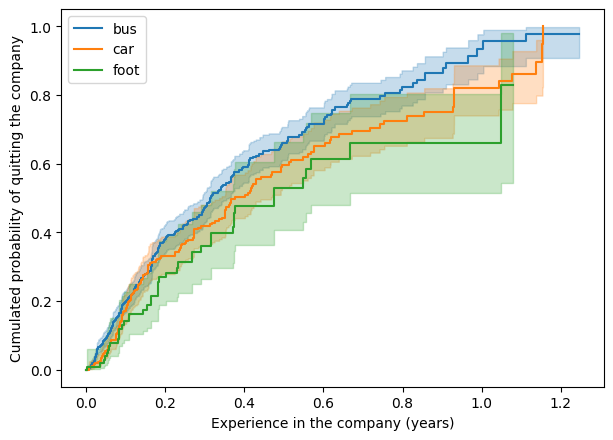

In [ ]:
plt.figure(figsize=(7, 5), dpi=100)
ax = plt.subplot()

kmf = KaplanMeierFitter()
variable_name = 'way'

for name, grouped_df in df_attrition.groupby(variable_name):
    kmf.fit(grouped_df.stag/12, grouped_df.event, label=name)
    ax = kmf.plot_cumulative_density(ax=ax)
    median_ = kmf.median_survival_time_
    median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
    print(f'{variable_name}_{name}\nMedian: {median_}\nCI: {median_confidence_interval_}\n')

# plt.title("Kaplan-Meier estimator for attrition")
plt.ylabel("Cumulated probability of quitting the company")
plt.xlabel("Experience in the company (years)")

without confidence intervals

Text(0.5, 0, 'Experience in the company (years)')

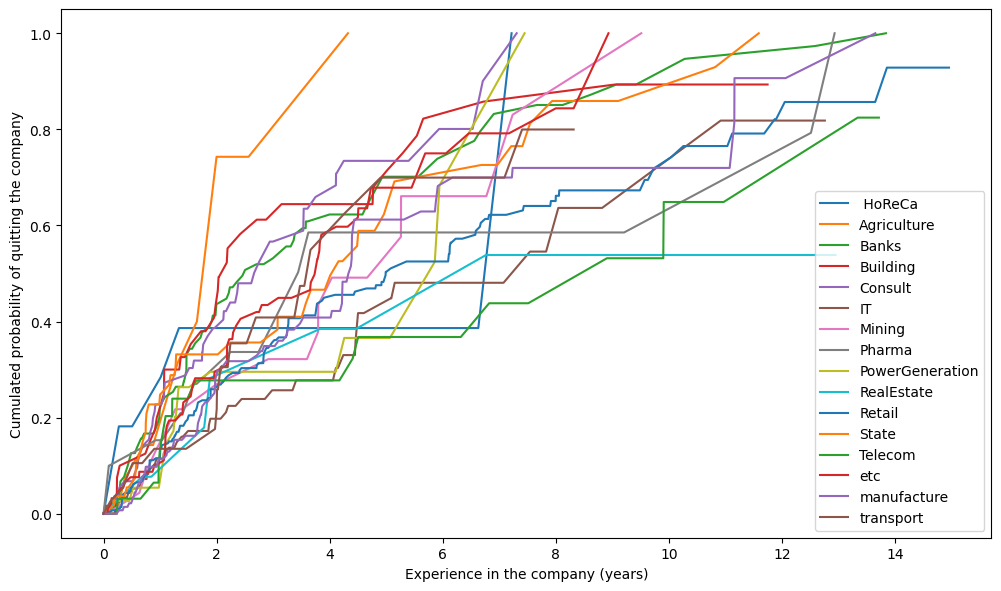

In [30]:
plt.figure(figsize=(12, 7), dpi=100)
ax = plt.subplot()

kmf = KaplanMeierFitter()
variable_name = 'industry'

for name, grouped_df in df_attrition.groupby(variable_name):
    kmf.fit(grouped_df.stag/12, grouped_df.event, label=name)
    # ax = kmf.plot_cumulative_density(ax=ax)
    ax = kmf.cumulative_density_.plot(ax = ax)
    median_ = kmf.median_survival_time_
    median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
    # print(f'{variable_name}_{name}\nMedian: {median_}\nCI: {median_confidence_interval_}\n')

# plt.title("Kaplan-Meier estimator for attrition")
plt.ylabel("Cumulated probability of quitting the company")
plt.xlabel("Experience in the company (years)")

with a layout

<Figure size 432x288 with 0 Axes>

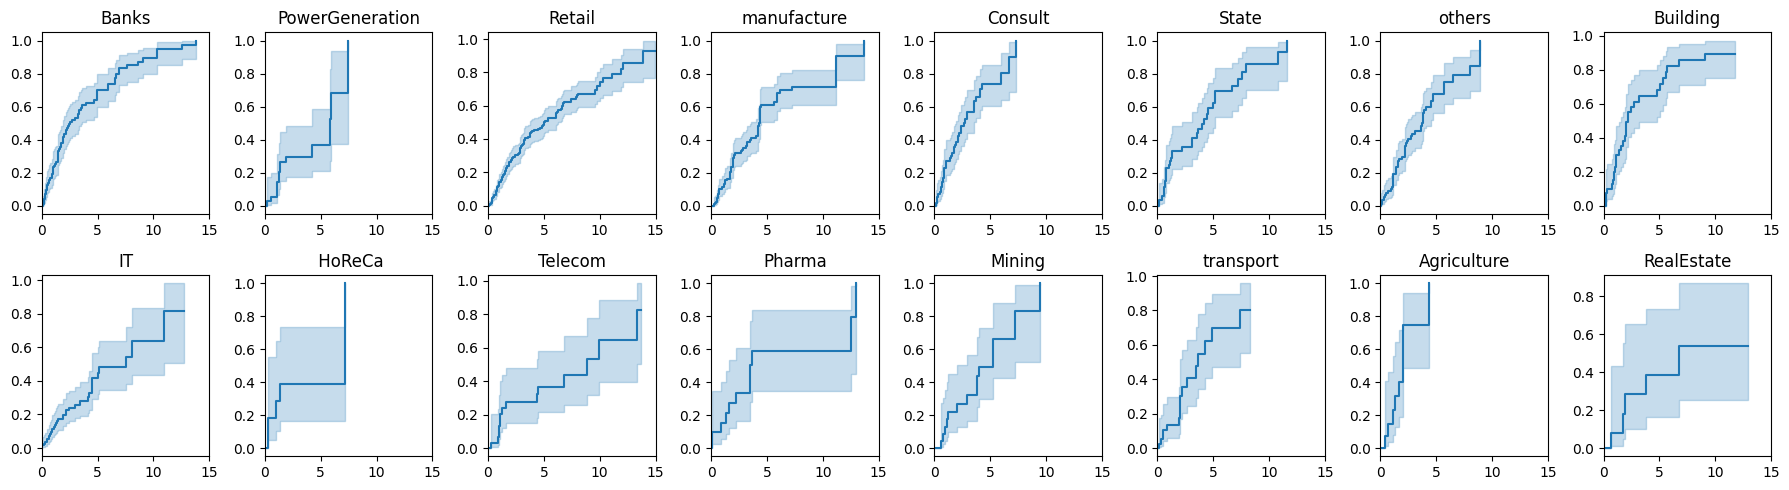

In [103]:
var_name = 'industry'
cat_list = df_attrition[var_name].unique()
fig = plt.figure()
plt.figure(figsize=(18, 5), dpi=100)

for i, cat in enumerate(cat_list):
    ax = plt.subplot(2, 8, i + 1)
    selected = df_attrition[var_name] == cat
    kmf.fit(df_attrition.stag[selected], df_attrition.event[selected], label=cat)
    kmf.plot_cumulative_density(ax=ax, legend=False)
    plt.title(cat)
    plt.xlim(0, 15)
    plt.ylabel('')
    plt.xlabel('')

plt.tight_layout()

#### Logrank test between multiple groups

 multivariate: Ho : all the populations have the same attrition generation process 

In [89]:
results = multivariate_logrank_test(df_attrition.stag, df_attrition['profession'], df_attrition.event)
results.print_summary()
# results.print_summary(style="latex")

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 14
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
          29.59 0.01      6.85

In [80]:
results = multivariate_logrank_test(df_attrition.stag, df_attrition['industry'], df_attrition.event)
results.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 15
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          60.93 <0.005     22.45

pairwise logrank test:

In [ ]:
results = pairwise_logrank_test(df_attrition.stag, df_attrition['way'], df_attrition.event)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
          test_statistic      p  -log2(p)
bus car             5.94   0.01      6.08
    foot            8.02 <0.005      7.76
car foot            1.90   0.17      2.58

In [ ]:
results = pairwise_logrank_test(df_attrition.stag, df_attrition['greywage'], df_attrition.event)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
            test_statistic      p  -log2(p)
grey white           22.34 <0.005     18.74

<lifelines.SplineFitter:"SplineFitter: 3 internal knot", fitted with 1129 total observations, 558 right-censored observations>


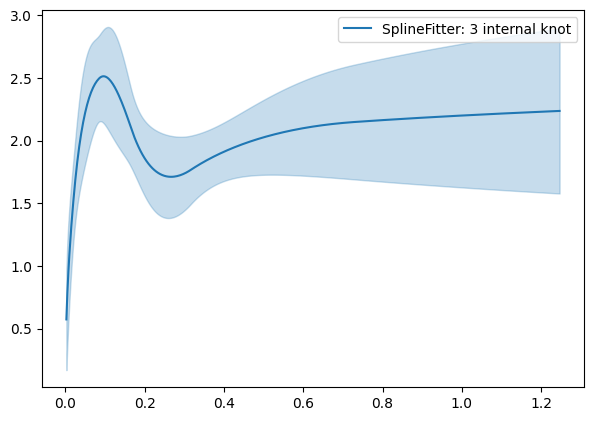

In [ ]:
best_model, best_aic_ = find_best_parametric_model(df_attrition_one_hot_enc.stag/12, df_attrition_one_hot_enc.event, scoring_method="AIC")

print(best_model)
# <lifelines.SplineFitter:"SplineFitter: 3 internal knot", fitted with 1129 total observations, 558 right-censored observations>
plt.figure(figsize=(7, 5), dpi=100)
best_model.plot_hazard()

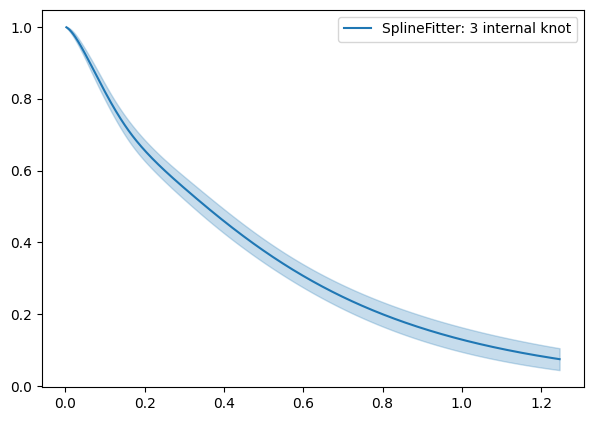

In [ ]:
plt.figure(figsize=(7, 5), dpi=100)
best_model.plot_survival_function()